In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import math

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [10]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


# 데이터 준비

In [5]:
# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0
...,...,...,...,...,...,...
2021-02-17,83900.0,84200.0,83000.0,83200.0,83200.000000,18307735.0
2021-02-18,83200.0,83600.0,82100.0,82100.0,82100.000000,21327683.0
2021-02-19,82300.0,82800.0,81000.0,82600.0,82600.000000,25880879.0


In [7]:
ts.tail()

Date
2021-02-17    83200.0
2021-02-18    82100.0
2021-02-19    82600.0
2021-02-22    82200.0
2021-02-23    82000.0
Name: Close, dtype: float64

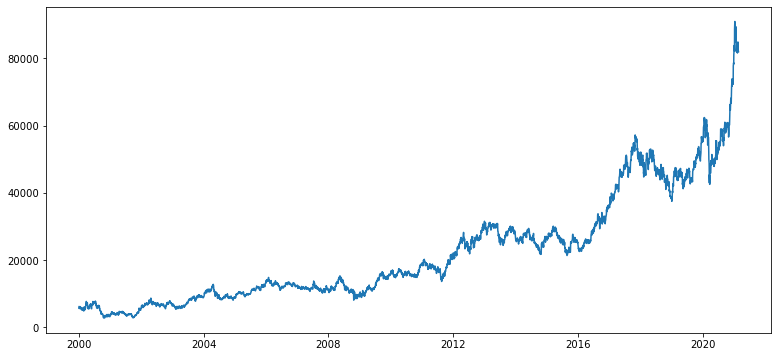

In [8]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

In [9]:
ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [10]:
ts_log = np.log(ts)

꾸준히 성장한 삼성전자기 때문에 log를 통해서 안정화를 시켜준다. 

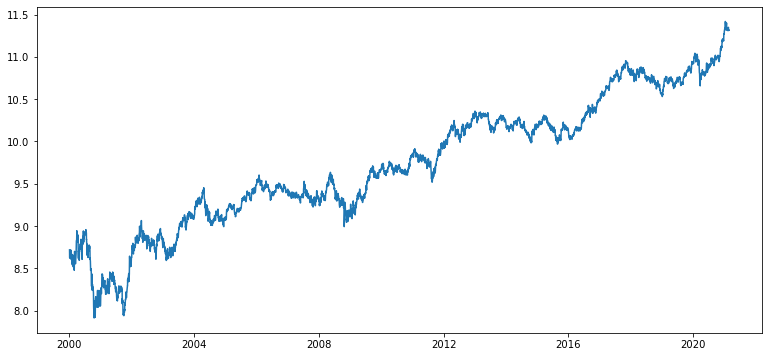

In [11]:
plt.plot(ts_log)

# stationary 검정


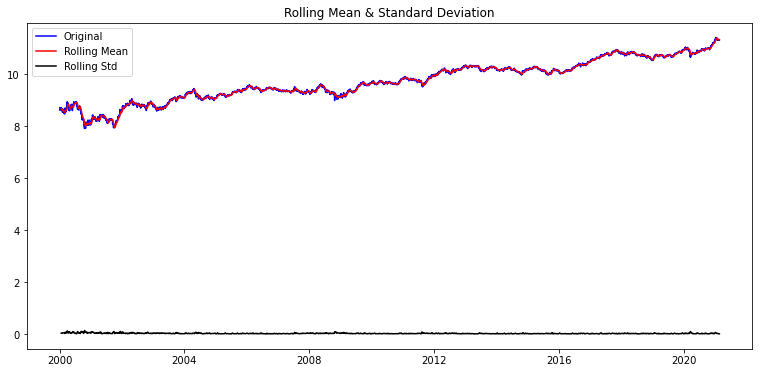

Results of Dickey-Fuller Test:
Test Statistic                   -0.327864
p-value                           0.921464
#Lags Used                        4.000000
Number of Observations Used    5310.000000
Critical Value (1%)              -3.431582
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


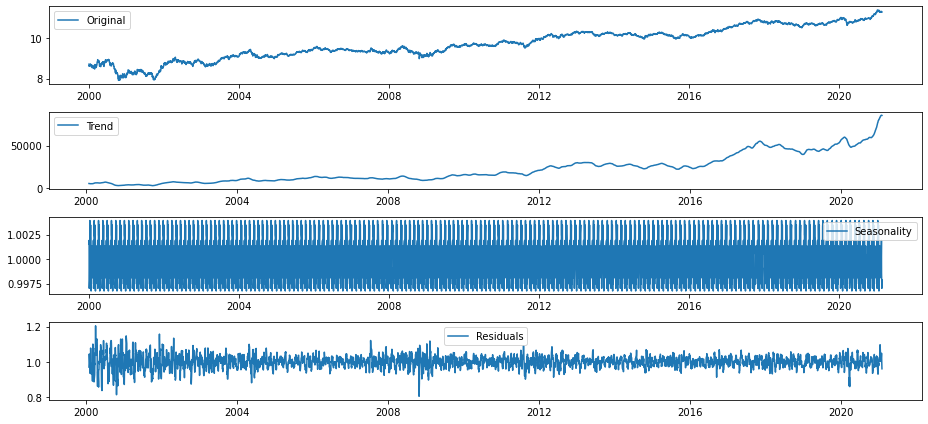

In [13]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [75]:
residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.730868e+01
p-value                        5.571623e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.251000e+03
Critical Value (1%)           -3.431596e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


residual은 상당히 stationary함을 볼 수 있다.

# train, test 데이터 분리

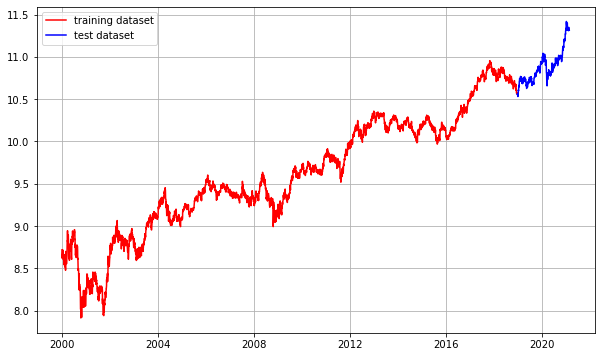

In [77]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.9)], ts_log[int(len(ts_log)* 0.9 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(train_data, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


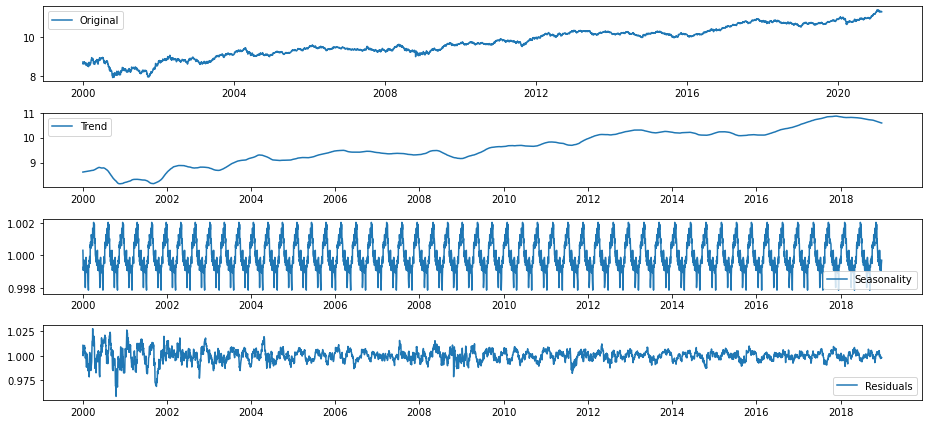

In [87]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_data, model='multiplicative', period = 90, extrapolate_trend = 1)
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [99]:
residual.index

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-17',
               ...
               '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14',
               '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-24'],
              dtype='datetime64[ns]', name='Date', length=4783, freq=None)

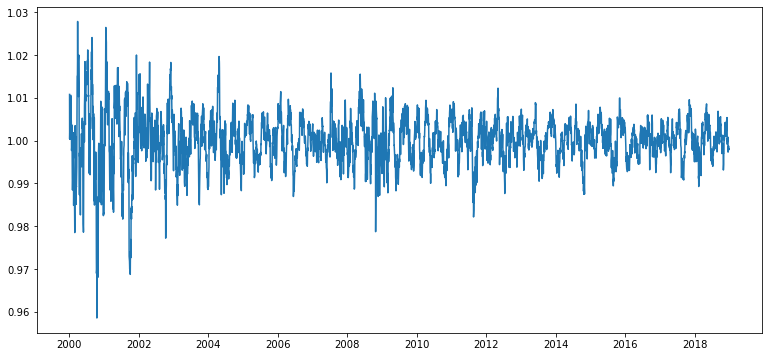

In [88]:
plt.plot(residual)

In [89]:
# ts = ts.interpolate(method = 'time')
residual[residual.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: resid, dtype: float64)

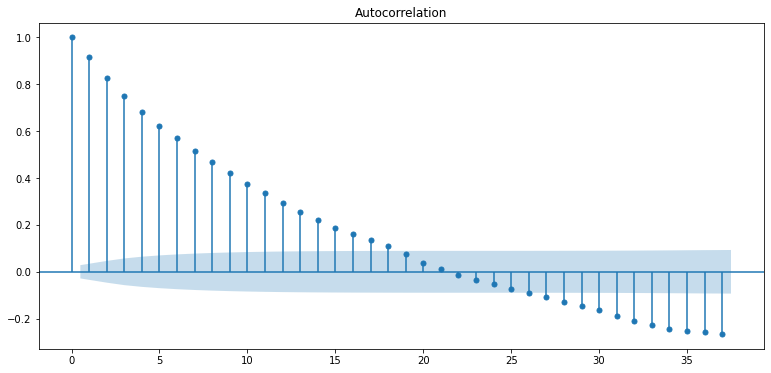

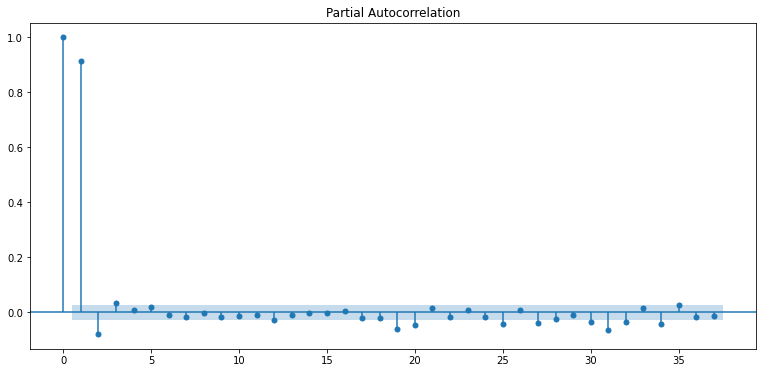

In [90]:
plot_acf(residual)
plot_pacf(residual)
plt.show()

In [91]:
pacf와 acf를 봤을때 ar(1)이나 ar(2)가 적절해보입니다. 

SyntaxError: invalid syntax (<ipython-input-91-becfdd34a4d3>, line 1)

# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



In [101]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(residual, order = (1,0,0))
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                 4783
Model:                     ARMA(1, 0)   Log Likelihood               22000.280
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 27 Feb 2021   AIC                         -43994.560
Time:                        14:23:39   BIC                         -43975.141
Sample:                             0   HQIC                        -43987.738
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0000      0.000   2394.902      0.000       0.999       1.001
ar.L1.resid     0.9160      0.006    157.887      0.000       0.905       0.927
                                    Roots       

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [103]:
fc

array([0.99830026, 0.99844473, 0.99857706, 0.99869827, 0.99880929,
       0.99891098, 0.99900413, 0.99908944, 0.99916759, 0.99923917,
       0.99930473, 0.99936478, 0.99941979, 0.99947017, 0.99951632,
       0.99955859, 0.9995973 , 0.99963277, 0.99966525, 0.999695  ,
       0.99972225, 0.99974721, 0.99977008, 0.99979102, 0.9998102 ,
       0.99982777, 0.99984387, 0.99985861, 0.99987211, 0.99988448,
       0.9998958 , 0.99990618, 0.99991568, 0.99992439, 0.99993236,
       0.99993967, 0.99994635, 0.99995248, 0.99995809, 0.99996323,
       0.99996794, 0.99997226, 0.99997621, 0.99997982, 0.99998314,
       0.99998617, 0.99998896, 0.9999915 , 0.99999384, 0.99999597,
       0.99999793, 0.99999972, 1.00000136, 1.00000287, 1.00000425,
       1.00000551, 1.00000666, 1.00000772, 1.00000869, 1.00000958,
       1.00001039, 1.00001114, 1.00001182, 1.00001245, 1.00001302,
       1.00001354, 1.00001402, 1.00001446, 1.00001487, 1.00001524,
       1.00001557, 1.00001588, 1.00001617, 1.00001643, 1.00001

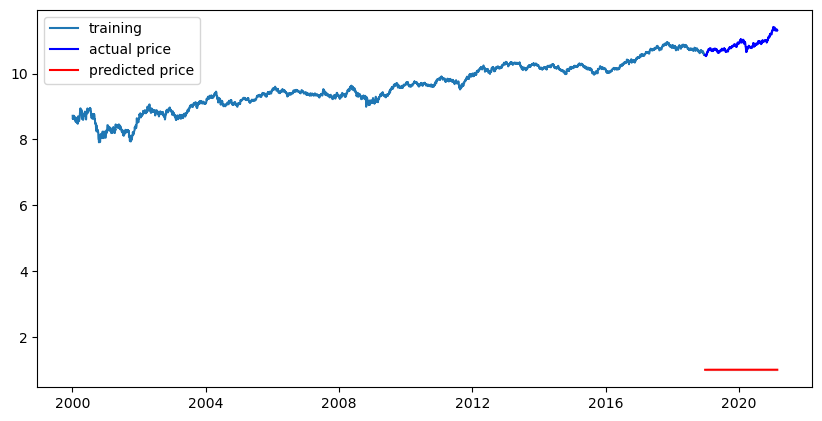

In [102]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  203975843.02626687
MAE:  10948.040322744026
RMSE:  14282.011168818868
MAPE: 18.16%


# STEP 7 : 다른 주식 종목 예측해 보기

# 넷플릭스 

# 데이터 준비

In [33]:
# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/NFLX.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2002-05-23    1.196429
2002-05-24    1.210000
2002-05-28    1.157143
2002-05-29    1.103571
2002-05-30    1.071429
Name: Close, dtype: float64

In [41]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
...,...,...,...,...,...,...
2021-02-16,557.289978,563.630005,552.729980,557.280029,557.280029,2622400
2021-02-17,550.989990,555.250000,543.030029,551.340027,551.340027,2069600
2021-02-18,549.000000,550.000000,538.229980,548.219971,548.219971,2456200


In [42]:
ts.tail()

Date
2021-02-16    557.280029
2021-02-17    551.340027
2021-02-18    548.219971
2021-02-19    540.219971
2021-02-22    533.780029
Name: Close, dtype: float64

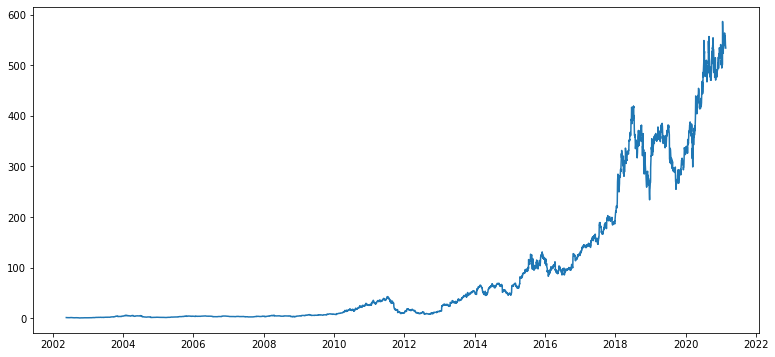

In [43]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

In [44]:
ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [45]:
ts_log = np.log(ts)

# stationary 검정


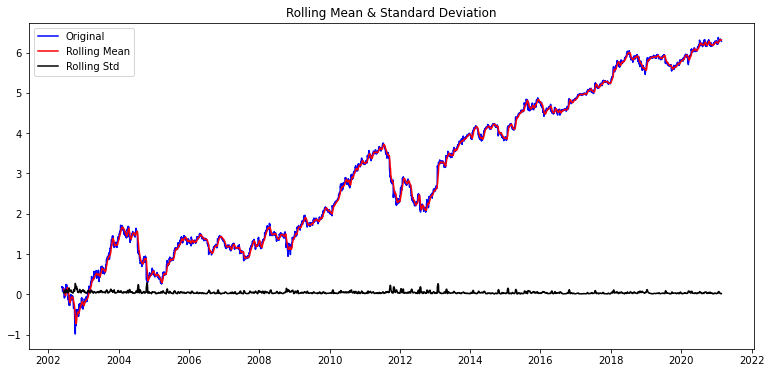

Results of Dickey-Fuller Test:
Test Statistic                   -0.418443
p-value                           0.906974
#Lags Used                        1.000000
Number of Observations Used    4718.000000
Critical Value (1%)              -3.431737
Critical Value (5%)              -2.862153
Critical Value (10%)             -2.567096
dtype: float64


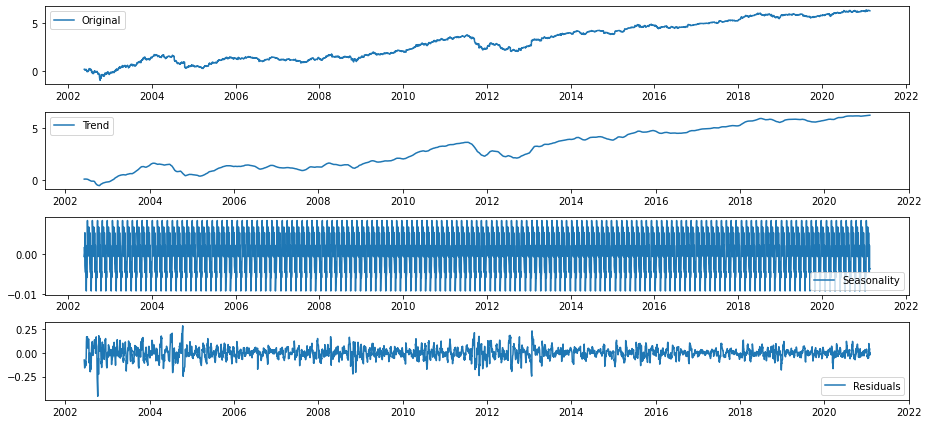

In [46]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [47]:
residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.681437e+01
p-value                        1.192032e-29
#Lags Used                     3.200000e+01
Number of Observations Used    4.657000e+03
Critical Value (1%)           -3.431755e+00
Critical Value (5%)           -2.862161e+00
Critical Value (10%)          -2.567100e+00
dtype: float64


residual은 상당히 stationary함을 볼 수 있다.

# train, test 데이터 분리

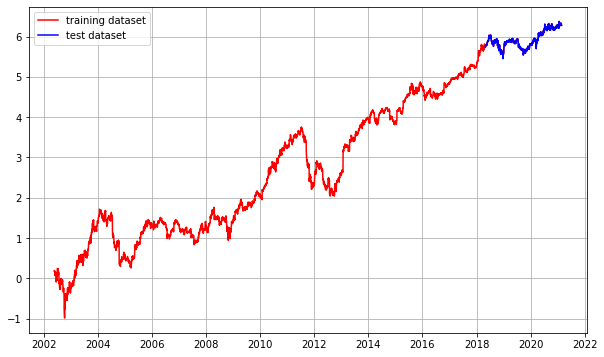

In [48]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.85)], ts_log[int(len(ts_log)* 0.85 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_log, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


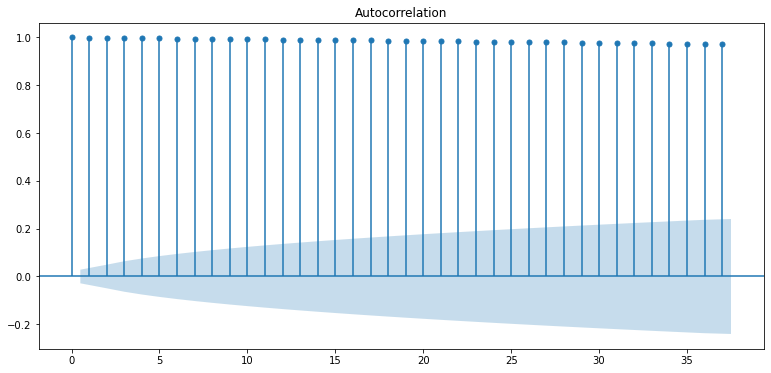

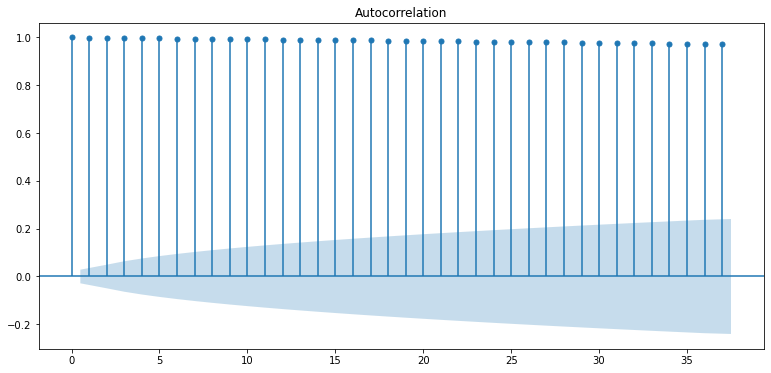

In [49]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

plot_acf(ts_log)
plot_acf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -66.814359
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    4718.000000
Critical Value (1%)              -3.431737
Critical Value (5%)              -2.862153
Critical Value (10%)             -2.567096
dtype: float64


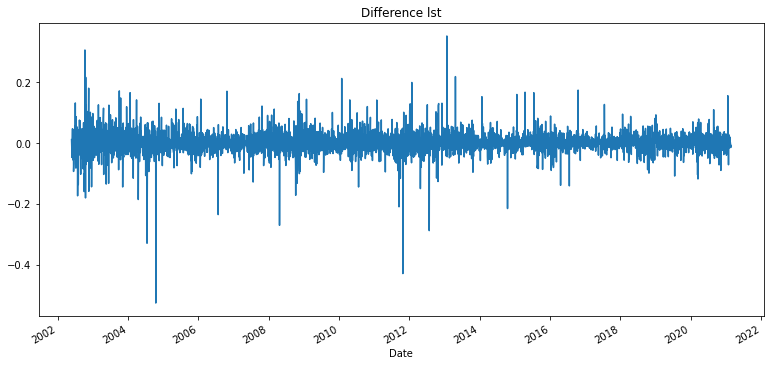

In [50]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]

# 1차 차분
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference lst')

augmented_dickey_fuller_test(diff_1)

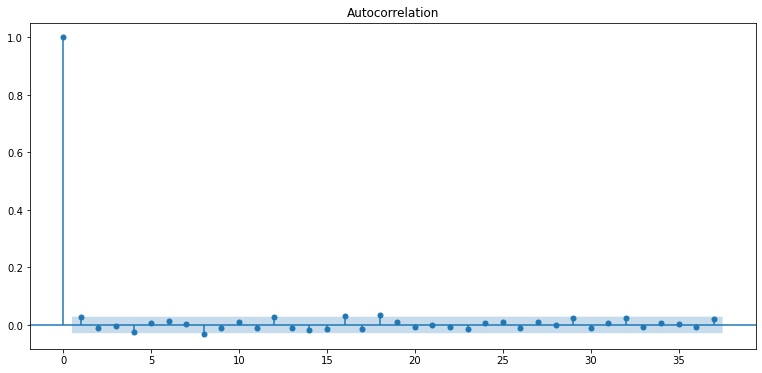

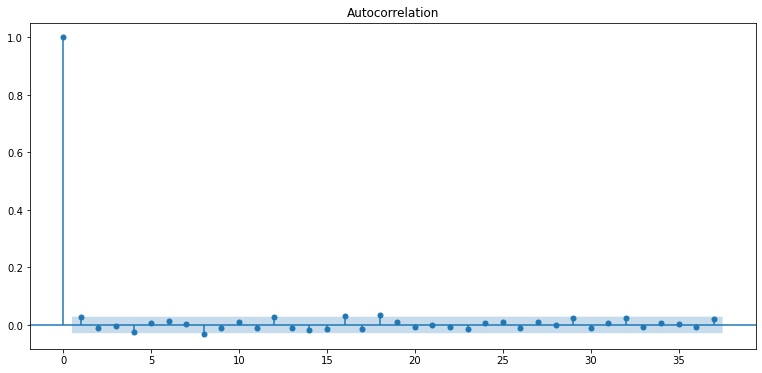

In [51]:

plot_acf(diff_1)
plot_acf(diff_1)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -21.108509
p-value                           0.000000
#Lags Used                       32.000000
Number of Observations Used    4685.000000
Critical Value (1%)              -3.431747
Critical Value (5%)              -2.862157
Critical Value (10%)             -2.567098
dtype: float64


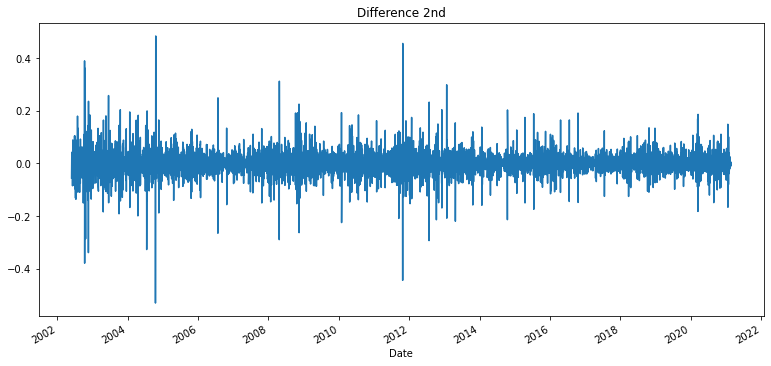

In [52]:
# 2차 차분 
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')

augmented_dickey_fuller_test(diff_2)

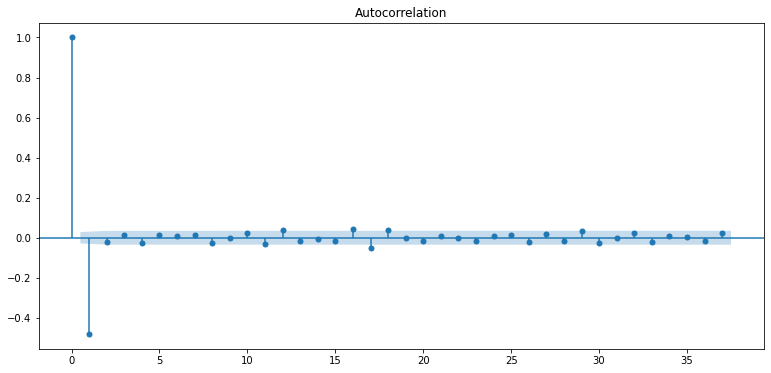

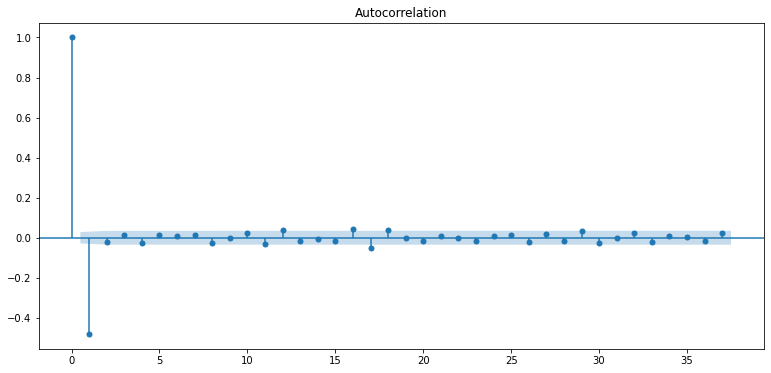

In [53]:

plot_acf(diff_2)
plot_acf(diff_2)
plt.show()

# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data)
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4012
Model:               SARIMAX(1, 0, 0)   Log Likelihood                7446.148
Date:                Tue, 02 Mar 2021   AIC                         -14888.296
Time:                        00:00:53   BIC                         -14875.702
Sample:                             0   HQIC                        -14883.832
                               - 4012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   8.91e-05   1.12e+04      0.000       1.000       1.000
sigma2         0.0014   9.02e-06    158.214      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   6.40   Jarque-

4012    5.744203
4013    5.743929
4014    5.743656
4015    5.743382
4016    5.743108
          ...   
4715    5.555018
4716    5.554754
4717    5.554489
4718    5.554224
4719    5.553960
Name: predicted_mean, Length: 708, dtype: float64
Date
2018-05-01   NaN
2018-05-02   NaN
2018-05-03   NaN
2018-05-04   NaN
2018-05-07   NaN
              ..
2021-02-16   NaN
2021-02-17   NaN
2021-02-18   NaN
2021-02-19   NaN
2021-02-22   NaN
Name: predicted_mean, Length: 708, dtype: float64


/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


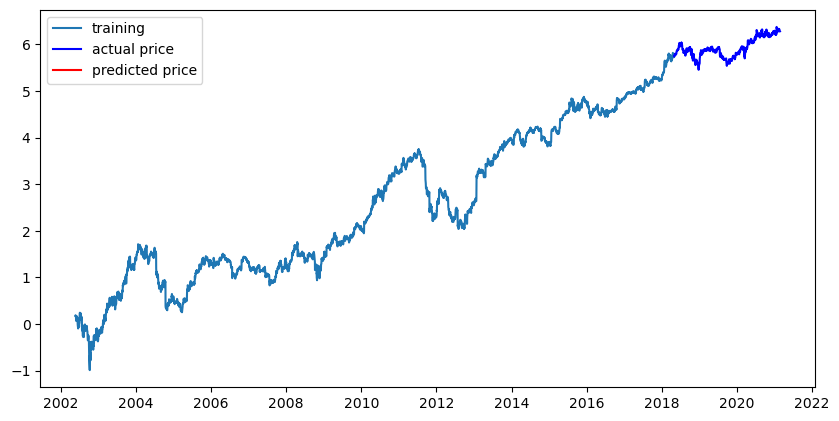

In [106]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc= fitted_m.forecast(len(test_data), alpha = 0.05) 
print(fc)

fc.set_axis = test_data.index
# Make as pandas series
# [[YOUR CODE]]
# fc_series = pd.Series(fc, index = test_data.index)
print(fc_series)
# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')

plt.legend()
plt.show()

In [107]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order = (1,0,3))
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4012
Model:                     ARMA(1, 3)   Log Likelihood                7450.772
Method:                       css-mle   S.D. of innovations              0.038
Date:                Tue, 02 Mar 2021   AIC                         -14889.544
Time:                        00:09:19   BIC                         -14851.762
Sample:                             0   HQIC                        -14876.153
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.8741      2.209      1.301      0.193      -1.455       7.203
ar.L1.Close     0.9999      0.000   6297.548      0.000       1.000       1.000
ma.L1.Close     0.0423      0.016      2.674    

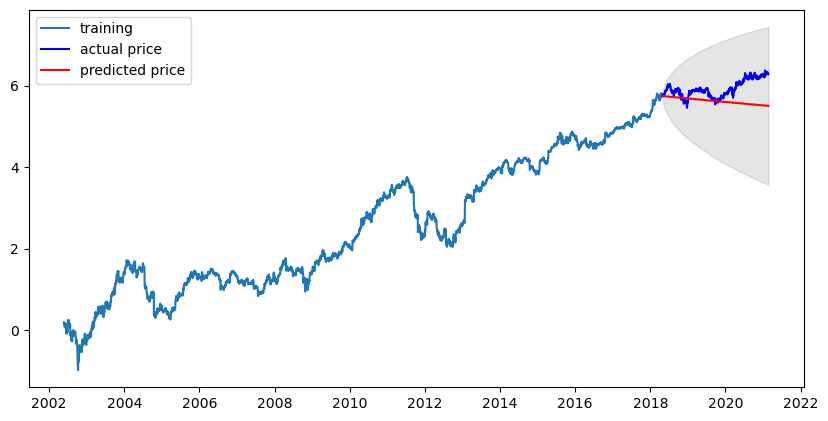

In [108]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  20246.99094428947
MAE:  108.87516750928182
RMSE:  142.2919215707254
MAPE: 25.03%


# STEP 7 : 다른 주식 종목 예측해 보기

# 마이크로소프트

# 데이터 준비

In [110]:
# Time Series 생성
dataset_filepath  = os.getenv('HOME')  + '/aiffel/stock_prediction/data/MSFT.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
1986-03-13    0.097222
1986-03-14    0.100694
1986-03-17    0.102431
1986-03-18    0.099826
1986-03-19    0.098090
Name: Close, dtype: float64

In [111]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061751,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063956,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065059,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063405,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062302,47894400
...,...,...,...,...,...,...
2021-02-16,245.029999,246.130005,242.919998,243.699997,243.139999,26708200
2021-02-17,241.320007,244.309998,240.940002,244.199997,244.199997,21653500
2021-02-18,241.800003,243.929993,240.860001,243.789993,243.789993,16910900


In [112]:
ts.tail()

Date
2021-02-16    243.699997
2021-02-17    244.199997
2021-02-18    243.789993
2021-02-19    240.970001
2021-02-22    234.509995
Name: Close, dtype: float64

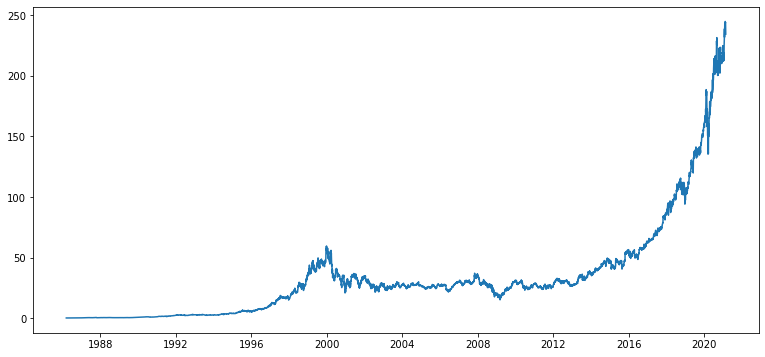

In [113]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 데이터 전처리

In [114]:
ts = ts.interpolate(method = 'time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [115]:
ts_log = np.log(ts)

# stationary 검정


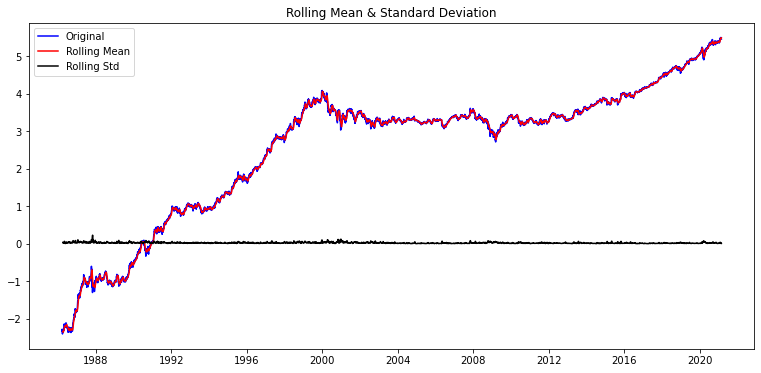

Results of Dickey-Fuller Test:
Test Statistic                   -2.908163
p-value                           0.044407
#Lags Used                        4.000000
Number of Observations Used    8803.000000
Critical Value (1%)              -3.431093
Critical Value (5%)              -2.861868
Critical Value (10%)             -2.566945
dtype: float64


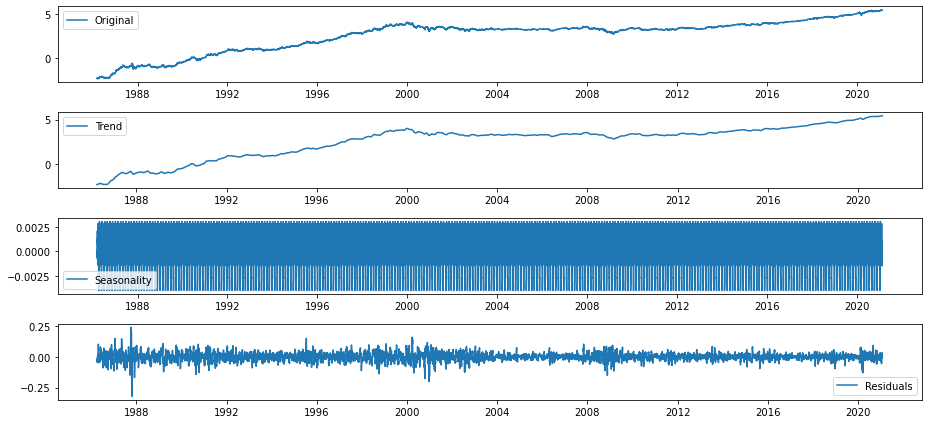

In [117]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [118]:
residual.dropna(inplace =True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -23.249267
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8740.000000
Critical Value (1%)              -3.431098
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64


residual은 상당히 stationary함을 볼 수 있다.

# train, test 데이터 분리

In [288]:
from scipy.stats import boxcox

In [307]:
ts.values

array([9.72220000e-02, 1.00694000e-01, 1.02431000e-01, ...,
       2.43789993e+02, 2.40970001e+02, 2.34509995e+02])

In [334]:
ts_power = boxcox(ts.values)
ts_power, _ = ts_power
print(type(ts_power))
print(ts_power)

len(ts_power)
len(ts_log)

<class 'numpy.ndarray'>
[-1.73757894 -1.71860055 -1.70928576 ... 12.44796702 12.3979303
 12.28166449]


8808

In [337]:
ts_power = pd.Series(ts_power, index = ts.index)
ts_power

Date
1986-03-13    -1.737579
1986-03-14    -1.718601
1986-03-17    -1.709286
1986-03-18    -1.723300
1986-03-19    -1.732788
                ...    
2021-02-16    12.446377
2021-02-17    12.455207
2021-02-18    12.447967
2021-02-19    12.397930
2021-02-22    12.281664
Length: 8808, dtype: float64

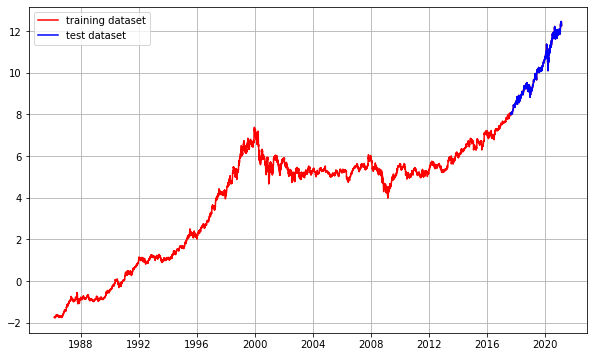

In [338]:
train_data, test_data = ts_power[ : int(len(ts_power)*0.90)],ts_power[int(len(ts_power)* 0.90 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_power, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

In [298]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.90)], ts_log[int(len(ts_log)* 0.90 ): ]
print(type(train_data))

<class 'pandas.core.series.Series'>


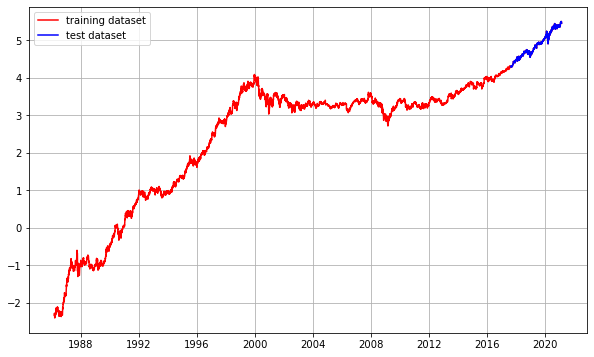

In [286]:
train_data, test_data = ts_log[ : int(len(ts_log)*0.90)], ts_log[int(len(ts_log)* 0.90 ): ]
plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_log, c = 'r', label = 'training dataset')

plt.plot(test_data, c = 'b', label = 'test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기


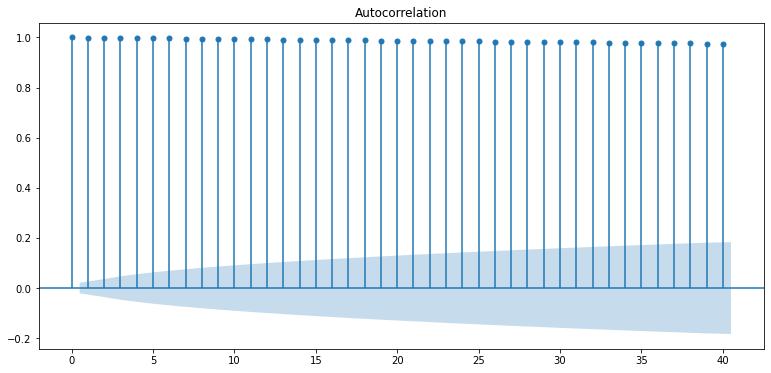

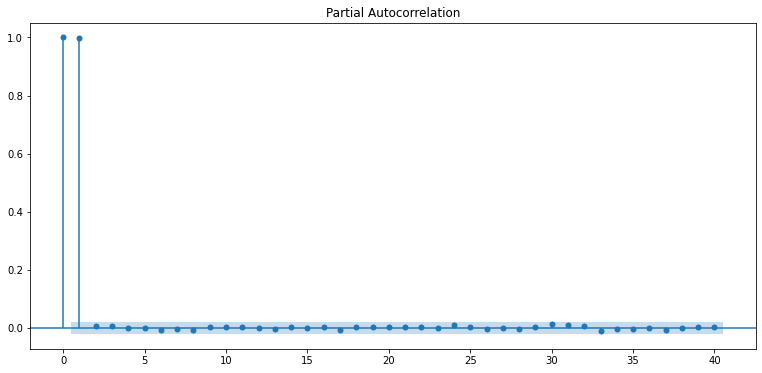

In [267]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -50.331009
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    8803.000000
Critical Value (1%)              -3.431093
Critical Value (5%)              -2.861868
Critical Value (10%)             -2.566945
dtype: float64


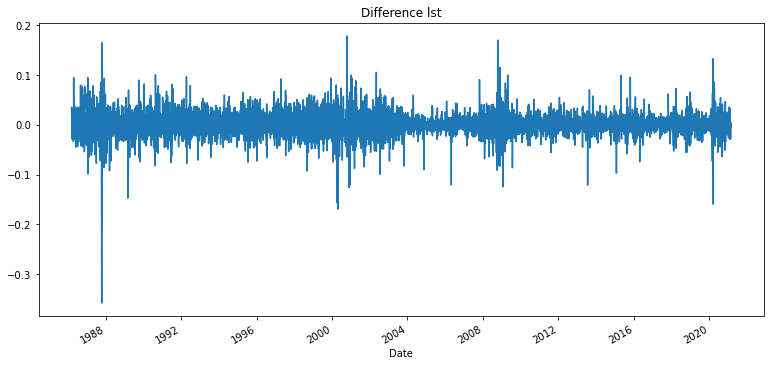

In [268]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]

# 1차 차분
diff_1 = ts_log.diff(periods = 1).iloc[1:]
diff_1.plot(title = 'Difference lst')

augmented_dickey_fuller_test(diff_1)

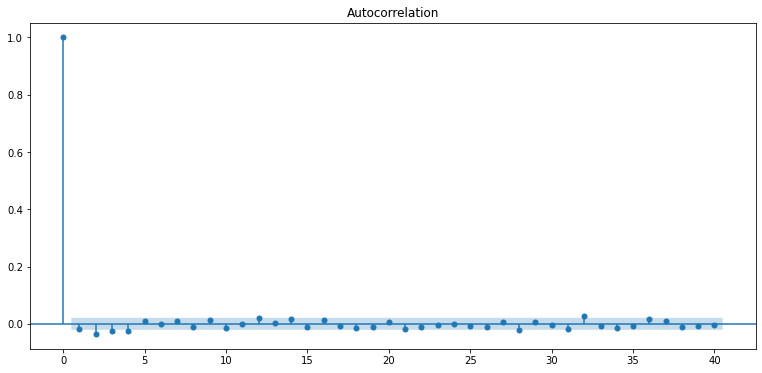

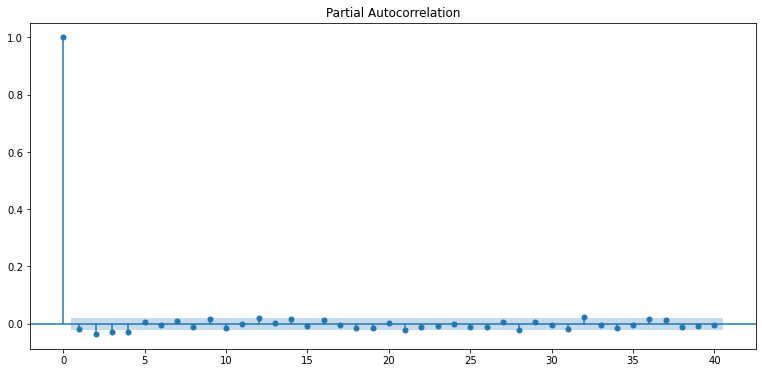

In [269]:

plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -26.525811
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8768.000000
Critical Value (1%)              -3.431096
Critical Value (5%)              -2.861870
Critical Value (10%)             -2.566945
dtype: float64


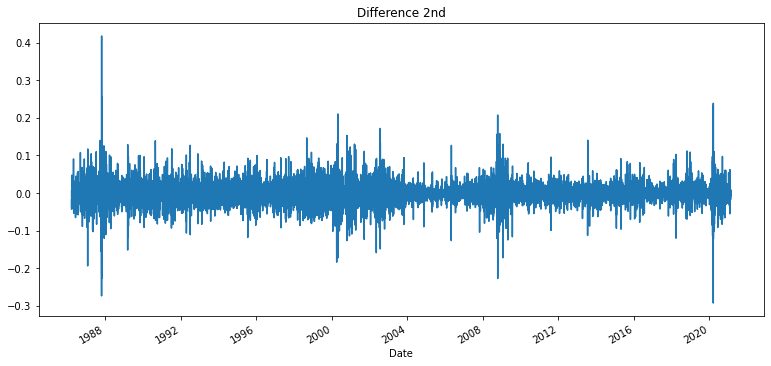

In [270]:
# 2차 차분 
diff_2 = diff_1.diff(periods = 1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')

augmented_dickey_fuller_test(diff_2)

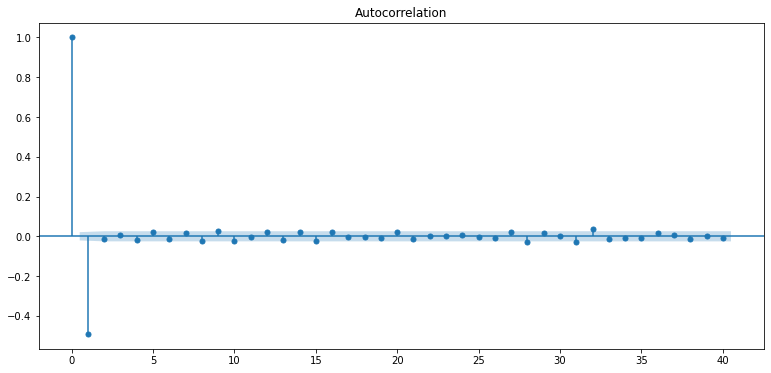

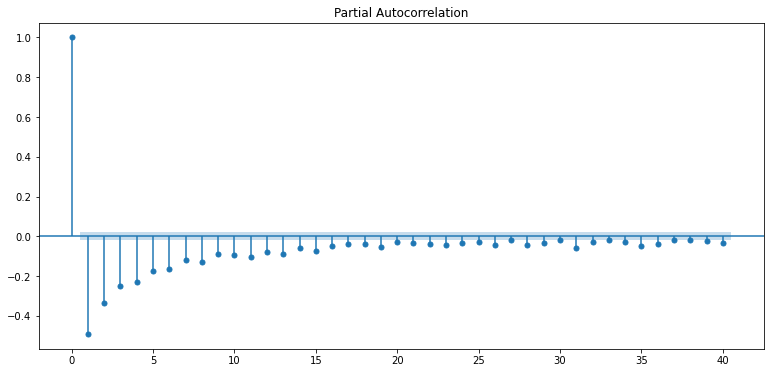

In [271]:

plot_acf(diff_2)
plot_pacf(diff_2)
plt.show()

# STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련                
모델 테스트 및 플로팅     
최종 예측 모델 정확도 측정(MAPE)                



In [352]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order = (0,2,1))
fitted_m = model.fit(disp = -1)
print(fitted_m.summary())

/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 7925
Model:                 ARIMA(0, 2, 1)   Log Likelihood               13725.317
Method:                       css-mle   S.D. of innovations              0.043
Date:                Tue, 02 Mar 2021   AIC                         -27444.633
Time:                        00:48:41   BIC                         -27423.700
Sample:                             2   HQIC                        -27437.465
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.864e-08   1.94e-06      0.051      0.960   -3.71e-06    3.91e-06
ma.L1.D2.y    -0.9961      0.003   -297.864      0.000      -1.003      -0.990
                                    Roots           

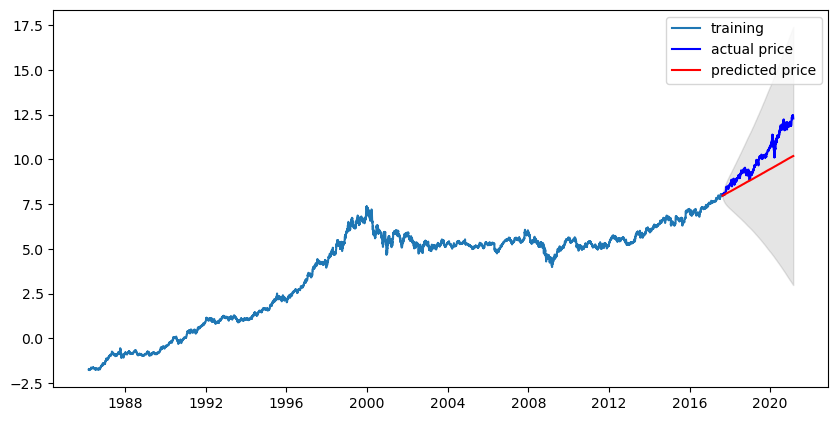

In [353]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05) 

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index= test_data.index)

# Plot
# [[YOUR CODE]]

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b' , label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = .10)
plt.legend()
plt.show()


In [354]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4051534881.6768494
MAE:  36880.130010630295
RMSE:  63651.66833380606
MAPE: 55.36%


# 소고